# Gaussian Mixture Models

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.labelsize': 10, 'font.size': 10, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")

## Step 1: Prepare the data

(array([  2.,  11.,  23.,   8.,   4.,  11.,   8.,   1.,  20.,  12.]),
 array([-8.58348848, -7.00993299, -5.43637751, -3.86282203, -2.28926654,
        -0.71571106,  0.85784443,  2.43139991,  4.0049554 ,  5.57851088,
         7.15206637]),
 <a list of 10 Patch objects>)

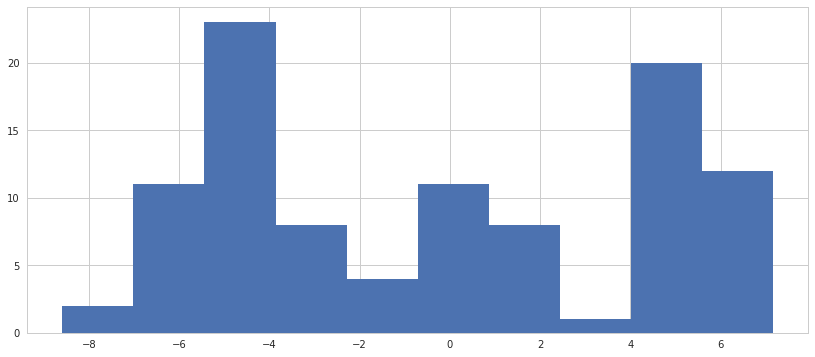

In [184]:
# simulate fake data with known mixture distribution
np.random.seed(123456)

k = 3
ndata = 100
spread = 5
centers = np.array([-spread, 0, spread])
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)
plt.hist(data)

In [185]:
centers

array([-5,  0,  5])

In [193]:
pd.value_counts(v)

0    44
2    33
1    23
dtype: int64

In [194]:
pd.value_counts(centers[v])

-5    44
 5    33
 0    23
dtype: int64

## Step 2: Build the model

In [215]:
with pm.Model() as gmm_model:
    
    # specify the priors
    p = pm.Dirichlet("p", a = np.array([1.0, 2.0, 1.0]), shape = k)
    means = pm.Normal("means", mu = [0, 0, 0], sd = 15, shape = k)
    sd = pm.Uniform("sd", lower = 0, upper = 20)
    
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))
    
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # latent cluster for each observation
    category = pm.Categorical("category", p = p, shape = ndata, testval = np.repeat(0.33333, ndata))
    
    # likelihood for each observation
    obs = pm.Normal("obs", mu = means[category], sd = sd, observed = data)
    
    # simulate data from this model
    simulated_obs = pm.Normal("simulated_obs", mu = means[category], sd = sd, shape = means[category].tag.test_value.shape)

In [216]:
p.tag.test_value

array([ 0.25,  0.5 ,  0.25])

In [210]:
means.tag.test_value

array([ 0.,  0.,  0.])

In [219]:
posterior["category"][10]

array([1, 2, 2, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0,
       0, 1, 0, 2, 0, 2, 1, 2, 0, 1, 0, 2, 0, 1, 2, 1, 0, 0, 2, 0, 2, 1, 2,
       2, 1, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       2, 1, 1, 0, 0, 2, 0, 2])

In [211]:
category.tag.test_value

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [212]:
means.tag.test_value[category.tag.test_value]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

## Step 3: Sample from the posterior

In [77]:
with gmm_model:
    step1 = pm.NUTS(vars = [p, means, sd, simulated_obs], target_accept = 0.9)
    step2 = pm.CategoricalGibbsMetropolis(vars = category)
    posterior = pm.sample(draws = 1000, njobs = 2, tune = 500, step = [step1, step2])

100%|█████████▉| 5975/6000 [05:42<00:01, 17.45it/s]/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 5999/6000 [05:43<00:00, 17.45it/s]/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 6000/6000 [05:43<00:00, 17.45it/s]


## Step 4: Diagnose convergence of MCMC chains

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77c081f748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f77d6c20160>]], dtype=object)

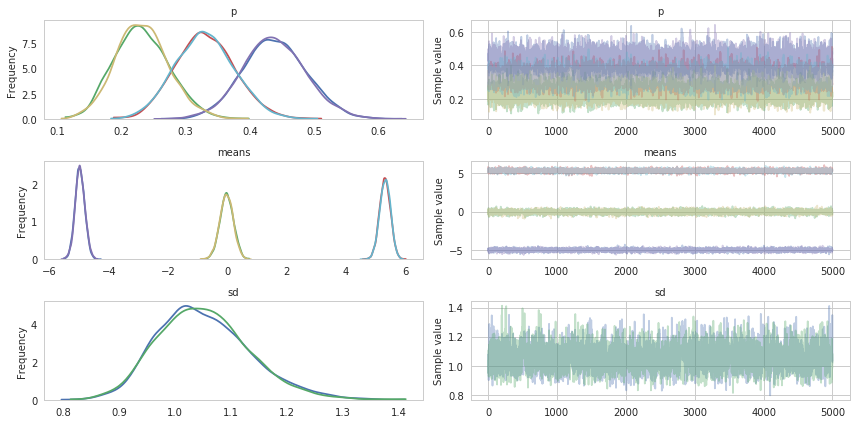

In [78]:
pm.traceplot(posterior, varnames = ["p", "means", "sd"])

In [79]:
pm.gelman_rubin(posterior, varnames = ["p", "means", "sd"])

{'means': array([ 1.00019006,  1.00019147,  1.0000181 ]),
 'p': array([ 0.99992211,  0.99996225,  0.99990466]),
 'sd': 0.99990585715916214}

In [80]:
#pm.energyplot(posterior)

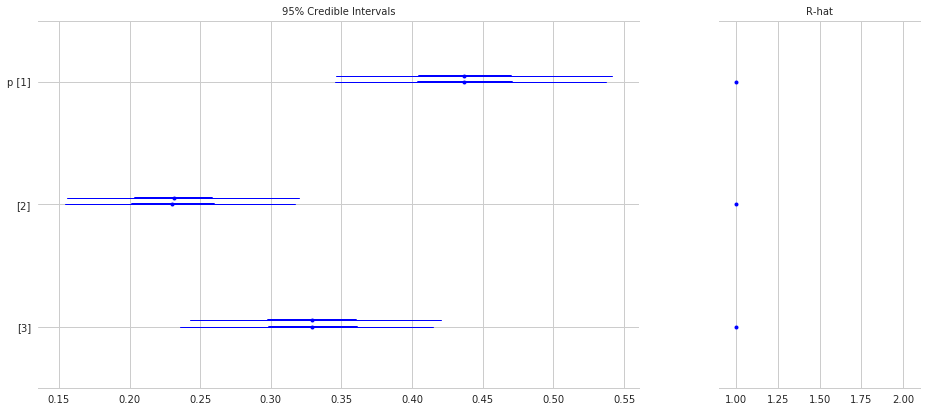

In [81]:
pm.forestplot(posterior, varnames = ["p"])

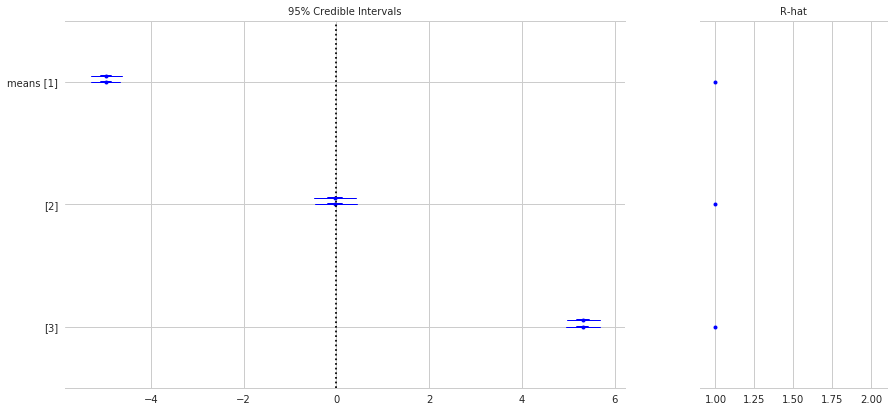

In [82]:
pm.forestplot(posterior, varnames = ["means"])

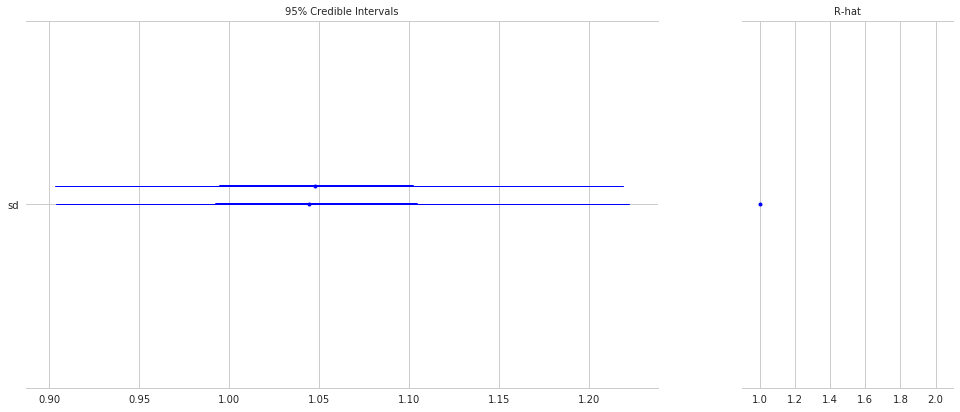

In [83]:
pm.forestplot(posterior, varnames = ["sd"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77d5c6a828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f77eba56748>]], dtype=object)

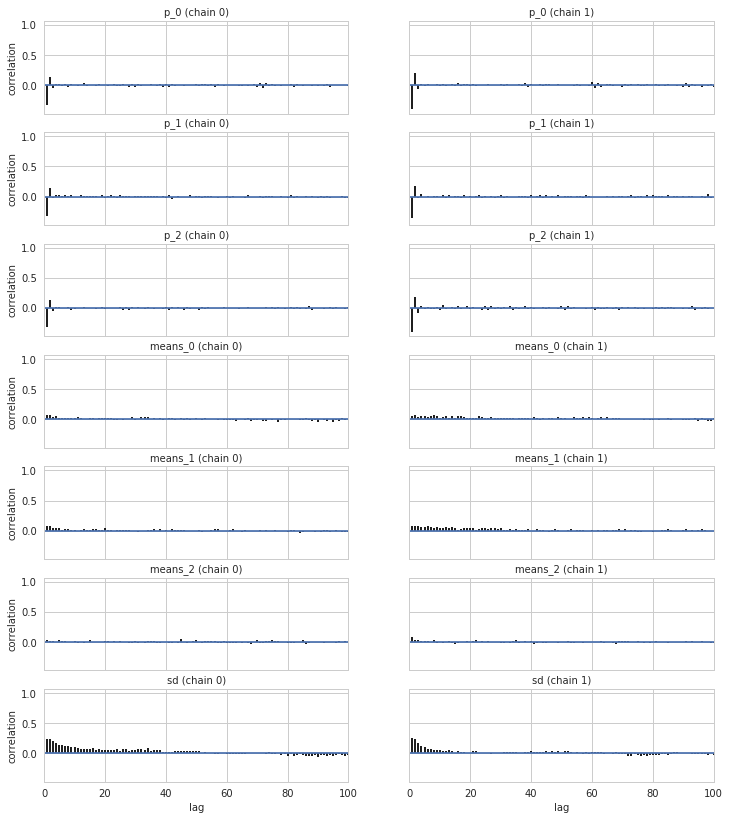

In [84]:
pm.autocorrplot(posterior, varnames = ["p", "means", "sd"])

## Step 5: Criticize the model

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f77d51b0e48>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f77e83342e8>], dtype=object)

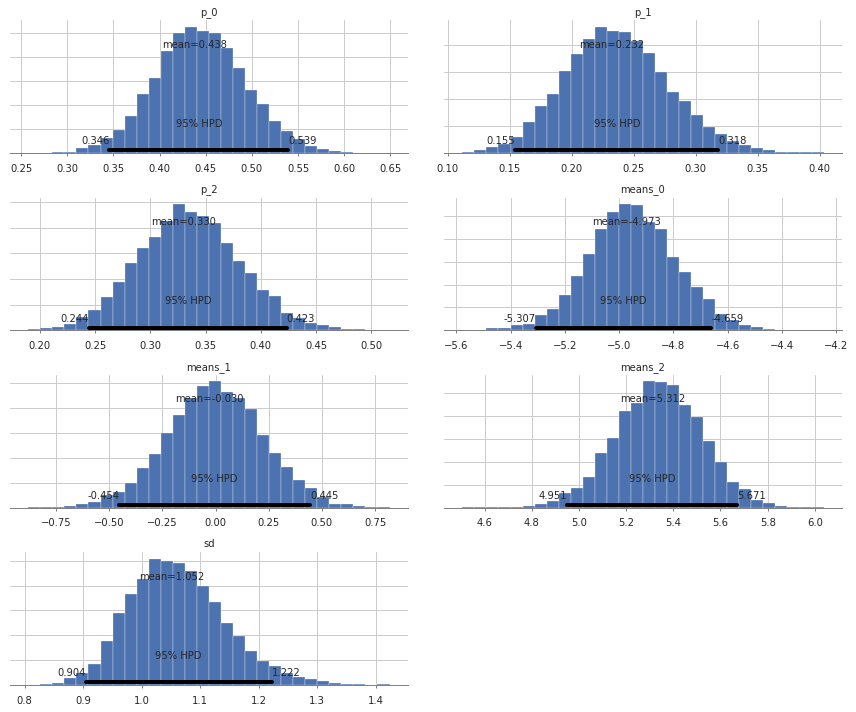

In [85]:
pm.plot_posterior(posterior, varnames = ["p", "means", "sd"])

In [86]:
pm.summary(posterior, varnames = ["p", "means", "sd"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p__0,0.437907,0.049210,0.000491,0.345616,0.539367,10000.0,0.999922
p__1,0.231933,0.041935,0.000425,0.154632,0.318203,10000.0,0.999962
p__2,0.330160,0.046027,0.000348,0.244445,0.423490,10000.0,0.999905
means__0,-4.972692,0.164321,0.003033,-5.306773,-4.659206,2430.0,1.000190
means__1,-0.030419,0.227677,0.004057,-0.453596,0.445214,2722.0,1.000191
means__2,5.312034,0.183470,0.002230,4.951391,5.671423,7090.0,1.000018
sd,1.051994,0.082103,0.001990,0.904439,1.222112,1365.0,0.999906


In [195]:
simulated_data = posterior["simulated_obs"]

In [196]:
simulated_data.shape

(10000, 100)

(array([   31.,   229.,   925.,  2137.,  2974.,  2340.,  1089.,   239.,
           33.,     3.]),
 array([-0.97008882, -0.85504704, -0.74000525, -0.62496346, -0.50992167,
        -0.39487988, -0.2798381 , -0.16479631, -0.04975452,  0.06528727,
         0.18032906]),
 <a list of 10 Patch objects>)

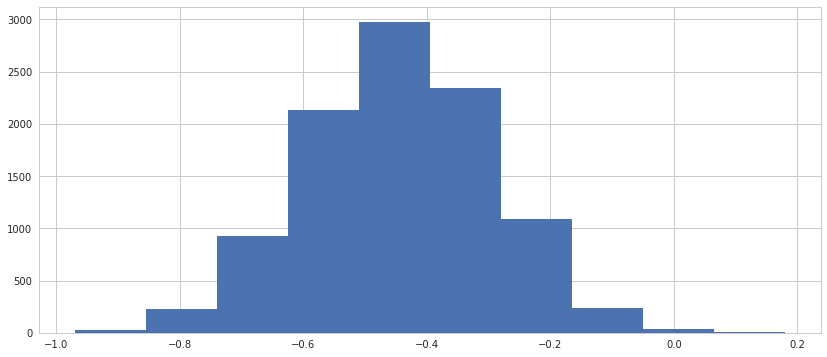

In [197]:
plt.hist(simulated_data.mean(axis = 1))